# Mod 4 Project - Starter Notebook

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [77]:
# Import necessary functions
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

%matplotlib inline


from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# Suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
# Import the dataset
df = pd.read_csv('data/zillow_data.csv')
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06  ...  2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0  ...  1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0  ...   308000   310000   312500   
2         3  210400.0  212200.0  212200.0  ...   321000   320600   320200   
3         4  498100.0  500900.0  503100.0  ...  1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

## Initial Look into the Dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


In [4]:
df.shape

(14723, 272)

In [5]:
df

RegionID  RegionName                 City State              Metro  \
0         84654       60657              Chicago    IL            Chicago   
1         90668       75070             McKinney    TX  Dallas-Fort Worth   
2         91982       77494                 Katy    TX            Houston   
3         84616       60614              Chicago    IL            Chicago   
4         93144       79936              El Paso    TX            El Paso   
...         ...         ...                  ...   ...                ...   
14718     58333        1338             Ashfield    MA    Greenfield Town   
14719     59107        3293            Woodstock    NH          Claremont   
14720     75672       40404                Berea    KY           Richmond   
14721     93733       81225  Mount Crested Butte    CO                NaN   
14722     95851       89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

### Addressing the 4 digit Zipcodes
The `RegionName` column contains the zipcodes of each region. Some of the zipcodes appear to be 4 digits long, but United States zipcodes consists of 5 digits. Let's add a zero at the beginining of the 4-digit zipcodes.

In [6]:
#df['RegionName'] = df['RegionName'].map("{:05}".format)
#df

#### 

In [7]:
#Add 0 the beginning until it reaches 5-digit length
df['RegionName'] = df['RegionName'].astype(str).str.zfill(5)
df

RegionID RegionName                 City State              Metro  \
0         84654      60657              Chicago    IL            Chicago   
1         90668      75070             McKinney    TX  Dallas-Fort Worth   
2         91982      77494                 Katy    TX            Houston   
3         84616      60614              Chicago    IL            Chicago   
4         93144      79936              El Paso    TX            El Paso   
...         ...        ...                  ...   ...                ...   
14718     58333      01338             Ashfield    MA    Greenfield Town   
14719     59107      03293            Woodstock    NH          Claremont   
14720     75672      40404                Berea    KY           Richmond   
14721     93733      81225  Mount Crested Butte    CO                NaN   
14722     95851      89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

# Step 2: Data Preprocessing

In [8]:
def get_datetimes(df):
    """
    Takes a dataframe:
    returns only those column names that can be converted into datetime objects 
    as datetime objects.
    NOTE number of returned columns may not match total number of columns in passed dataframe
    """
    
    return pd.to_datetime(df.columns.values[7:], format='%Y-%m')

In [9]:
get_datetimes(df)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [10]:
# checking total number of zip codes
print(f'There are {df.RegionName.nunique()} different zip codes in our dataset.')

There are 14723 different zip codes in our dataset.


In [11]:
df

RegionID RegionName                 City State              Metro  \
0         84654      60657              Chicago    IL            Chicago   
1         90668      75070             McKinney    TX  Dallas-Fort Worth   
2         91982      77494                 Katy    TX            Houston   
3         84616      60614              Chicago    IL            Chicago   
4         93144      79936              El Paso    TX            El Paso   
...         ...        ...                  ...   ...                ...   
14718     58333      01338             Ashfield    MA    Greenfield Town   
14719     59107      03293            Woodstock    NH          Claremont   
14720     75672      40404                Berea    KY           Richmond   
14721     93733      81225  Mount Crested Butte    CO                NaN   
14722     95851      89155             Mesquite    NV          Las Vegas   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-07  \
0           Cook         1  334200.0  335400.0  336500.0  ...  1005500   
1         Collin         2  235700.0  236900.0  236700.0  ...   308000   
2         Harris         3  210400.0  212200.0  212200.0  ...   321000   
3           Cook         4  498100.0  500900.0  503100.0  ...  1289800   
4        El Paso         5   77300.0   77300.0   77300.0  ...   119100   
...          ...       ...       ...       ...       ...  ...      ...   
14718   Franklin     14719   94600.0   94300.0   94000.0  ...   216800   
14719    Grafton     14720   92700.0   92500.0   92400.0  ...   202100   
14720    Madison     14721   57100.0   57300.0   57500.0  ...   121800   
14721   Gunnison     14722  191100.0  192400.0  193700.0  ...   662800   
14722      Clark     14723  176400.0  176300.0  176100.0  ...   333800   

       2017-08  2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  \
0      1007500  1007800  1009600  1013300  1018700  1024400  1030700  1033800   
1       310000   312500   314100   315000   316600   318100   319600   321100   
2       320600   320200   320400   320800   321200   321200   323000   326900   
3      1287700  1287400  1291500  1296600  1299000  1302700  1306400  1308500   
4       119400   120000   120300   120300   120300   120300   120500   121000   
...        ...      ...      ...      ...      ...      ...      ...      ...   
14718   217700   218600   218500   218100   216400   213100   209800   209200   
14719   208400   212200   215200   214300   213100   213700   218300   222700   
14720   122800   124600   126700   128800   130600   131700   132500   133000   
14721   671200   682400   695600   695500   694700   706400   705300   681500   
14722   336400   339700   343800   346800   348900   350400   353000   356000   

       2018-04  
0      1030600  
1       321800  
2       329900  
3      1307000  
4       121500  
...        ...  
14718   209300  
14719   225800  
14720   133400  
14721   664400  
14722   357200  

[14723 rows x 272 columns]

## 5-, 10-, 15-Year % Returns

In [12]:
df_copy = df.copy()
df_copy['five_year'] = ((df_copy['2018-04'] - df_copy['2013-04']) / df_copy['2013-04']) * 100
df_copy['ten_year'] = ((df_copy['2018-04'] - df_copy['2008-04']) / df_copy['2008-04']) * 100
df_copy['fifteen_year'] = ((df_copy['2018-04'] - df_copy['2003-04']) / df_copy['2003-04']) * 100

#sory by Descending Five-Year Return
df_copy.sort_values(by='five_year', ascending=False).head(10)

RegionID RegionName              City State                  Metro  \
7302     93292      80216            Denver    CO                 Denver   
1477     97803      94601           Oakland    CA          San Francisco   
5830     79095      48240           Redford    MI                Detroit   
1239     97795      94590           Vallejo    CA                Vallejo   
2661     72768      33705  Saint Petersburg    FL                  Tampa   
6105     74241      37210         Nashville    TN              Nashville   
2627     72619      33460        Lake Worth    FL  Miami-Fort Lauderdale   
6563     63932      15201        Pittsburgh    PA             Pittsburgh   
475      62027      11216          New York    NY               New York   
1835     74238      37207         Nashville    TN              Nashville   

      CountyName  SizeRank   1996-04   1996-05   1996-06  ...  2017-10  \
7302      Denver      7303       NaN       NaN       NaN  ...   247600   
1477     Alameda      1478  114600.0  114500.0  114500.0  ...   521100   
5830       Wayne      5831   67800.0   68200.0   68500.0  ...    68700   
1239      Solano      1240  108200.0  107800.0  107500.0  ...   346700   
2661    Pinellas      2662   54600.0   54800.0   55000.0  ...   162500   
6105    Davidson      6106   60800.0   61000.0   61200.0  ...   211100   
2627  Palm Beach      2628   59800.0   59900.0   60000.0  ...   200400   
6563   Allegheny      6564   34400.0   34600.0   34700.0  ...   167600   
475        Kings       476  146100.0  146600.0  147200.0  ...  1567700   
1835    Davidson      1836   63600.0   63600.0   63600.0  ...   186700   

      2017-11  2017-12  2018-01  2018-02  2018-03  2018-04   five_year  \
7302   249100   251200   253800   258100   263700   267300  173.872951   
1477   526700   535800   546900   555000   562000   566700  167.943262   
5830    69700    71000    72300    73500    75300    76800  161.224490   
1239   351200   357100   362500   366900   371600   376100  159.379310   
2661   165300   167100   168200   171100   175100   177300  159.210526   
6105   214500   217200   219300   221500   224300   226500  155.932203   
2627   202600   206000   209600   211600   213300   215600  153.647059   
6563   169000   170400   171400   173900   179700   185200  147.593583   
475   1559700  1545700  1540200  1553600  1578400  1598700  147.591761   
1835   188000   189500   191400   193900   197600   200800  146.683047   

        ten_year  fifteen_year  
7302         NaN           NaN  
1477   45.158811    100.815025  
5830  -22.891566    -33.621435  
1239   23.676422     39.658374  
2661   24.421053     89.828694  
6105  116.746411    178.940887  
2627   12.291667     75.856444  
6563  166.474820    313.392857  
475   122.226856    446.190639  
1835   93.635487    137.633136  

[10 rows x 275 columns]

# Step 4: Reshape from Wide to Long Format

In [13]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [14]:
ts = melt_data(df)
display(ts.head(10))
display(ts.info())

value
time                     
1996-04-01  118299.123063
1996-05-01  118419.044139
1996-06-01  118537.423268
1996-07-01  118653.069278
1996-08-01  118780.254312
1996-09-01  118927.528500
1996-10-01  119120.520316
1996-11-01  119345.352236
1996-12-01  119685.084771
1997-01-01  120121.265712

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265 entries, 1996-04-01 to 2018-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   265 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


None

In [15]:
#melt the dataset
melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')

#change to datetime dataframe
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)

#drop rows where value is missing
melted = melted.dropna(subset=['value'])

#set to datetime index
melted = melted.set_index('time')

melted

RegionName  RegionID  SizeRank                 City State  \
time                                                                   
1996-04-01      60657     84654         1              Chicago    IL   
1996-04-01      75070     90668         2             McKinney    TX   
1996-04-01      77494     91982         3                 Katy    TX   
1996-04-01      60614     84616         4              Chicago    IL   
1996-04-01      79936     93144         5              El Paso    TX   
...               ...       ...       ...                  ...   ...   
2018-04-01      01338     58333     14719             Ashfield    MA   
2018-04-01      03293     59107     14720            Woodstock    NH   
2018-04-01      40404     75672     14721                Berea    KY   
2018-04-01      81225     93733     14722  Mount Crested Butte    CO   
2018-04-01      89155     95851     14723             Mesquite    NV   

                        Metro CountyName     value  
time                                                
1996-04-01            Chicago       Cook  334200.0  
1996-04-01  Dallas-Fort Worth     Collin  235700.0  
1996-04-01            Houston     Harris  210400.0  
1996-04-01            Chicago       Cook  498100.0  
1996-04-01            El Paso    El Paso   77300.0  
...                       ...        ...       ...  
2018-04-01    Greenfield Town   Franklin  209300.0  
2018-04-01          Claremont    Grafton  225800.0  
2018-04-01           Richmond    Madison  133400.0  
2018-04-01                NaN   Gunnison  664400.0  
2018-04-01          Las Vegas      Clark  357200.0  

[3744704 rows x 8 columns]

### Any Missing Values?

In [16]:
#check for nulls
melted.isna().sum()

RegionName         0
RegionID           0
SizeRank           0
City               0
State              0
Metro         236023
CountyName         0
value              0
dtype: int64

Looks like there are missing values, but only in the 'Metro' column. We'll leave these in the dataset for now since we are focusing on the 'value' column.

### Renaming the 'RegionName' Column

In [17]:
#rename the zipcode column with appropriate name
melted = melted.rename(columns={'RegionName': 'ZipCode'})

#drop unique region ID column
melted = melted.drop('RegionID', axis=1)

melted

ZipCode  SizeRank                 City State              Metro  \
time                                                                         
1996-04-01   60657         1              Chicago    IL            Chicago   
1996-04-01   75070         2             McKinney    TX  Dallas-Fort Worth   
1996-04-01   77494         3                 Katy    TX            Houston   
1996-04-01   60614         4              Chicago    IL            Chicago   
1996-04-01   79936         5              El Paso    TX            El Paso   
...            ...       ...                  ...   ...                ...   
2018-04-01   01338     14719             Ashfield    MA    Greenfield Town   
2018-04-01   03293     14720            Woodstock    NH          Claremont   
2018-04-01   40404     14721                Berea    KY           Richmond   
2018-04-01   81225     14722  Mount Crested Butte    CO                NaN   
2018-04-01   89155     14723             Mesquite    NV          Las Vegas   

           CountyName     value  
time                             
1996-04-01       Cook  334200.0  
1996-04-01     Collin  235700.0  
1996-04-01     Harris  210400.0  
1996-04-01       Cook  498100.0  
1996-04-01    El Paso   77300.0  
...               ...       ...  
2018-04-01   Franklin  209300.0  
2018-04-01    Grafton  225800.0  
2018-04-01    Madison  133400.0  
2018-04-01   Gunnison  664400.0  
2018-04-01      Clark  357200.0  

[3744704 rows x 7 columns]

### Mid Zips

In [18]:
midzips = melted[(melted['ZipCode'] == '94590') |
                 (melted['ZipCode'] == '33705') |
                 (melted['ZipCode'] == '37210') |
                 (melted['ZipCode'] == '33460')]

midzips

ZipCode  SizeRank              City State                  Metro  \
time                                                                          
1996-04-01   94590      1240           Vallejo    CA                Vallejo   
1996-04-01   33460      2628        Lake Worth    FL  Miami-Fort Lauderdale   
1996-04-01   33705      2662  Saint Petersburg    FL                  Tampa   
1996-04-01   37210      6106         Nashville    TN              Nashville   
1996-05-01   94590      1240           Vallejo    CA                Vallejo   
...            ...       ...               ...   ...                    ...   
2018-03-01   37210      6106         Nashville    TN              Nashville   
2018-04-01   94590      1240           Vallejo    CA                Vallejo   
2018-04-01   33460      2628        Lake Worth    FL  Miami-Fort Lauderdale   
2018-04-01   33705      2662  Saint Petersburg    FL                  Tampa   
2018-04-01   37210      6106         Nashville    TN              Nashville   

            CountyName     value  
time                              
1996-04-01      Solano  108200.0  
1996-04-01  Palm Beach   59800.0  
1996-04-01    Pinellas   54600.0  
1996-04-01    Davidson   60800.0  
1996-05-01      Solano  107800.0  
...                ...       ...  
2018-03-01    Davidson  224300.0  
2018-04-01      Solano  376100.0  
2018-04-01  Palm Beach  215600.0  
2018-04-01    Pinellas  177300.0  
2018-04-01    Davidson  226500.0  

[1060 rows x 7 columns]

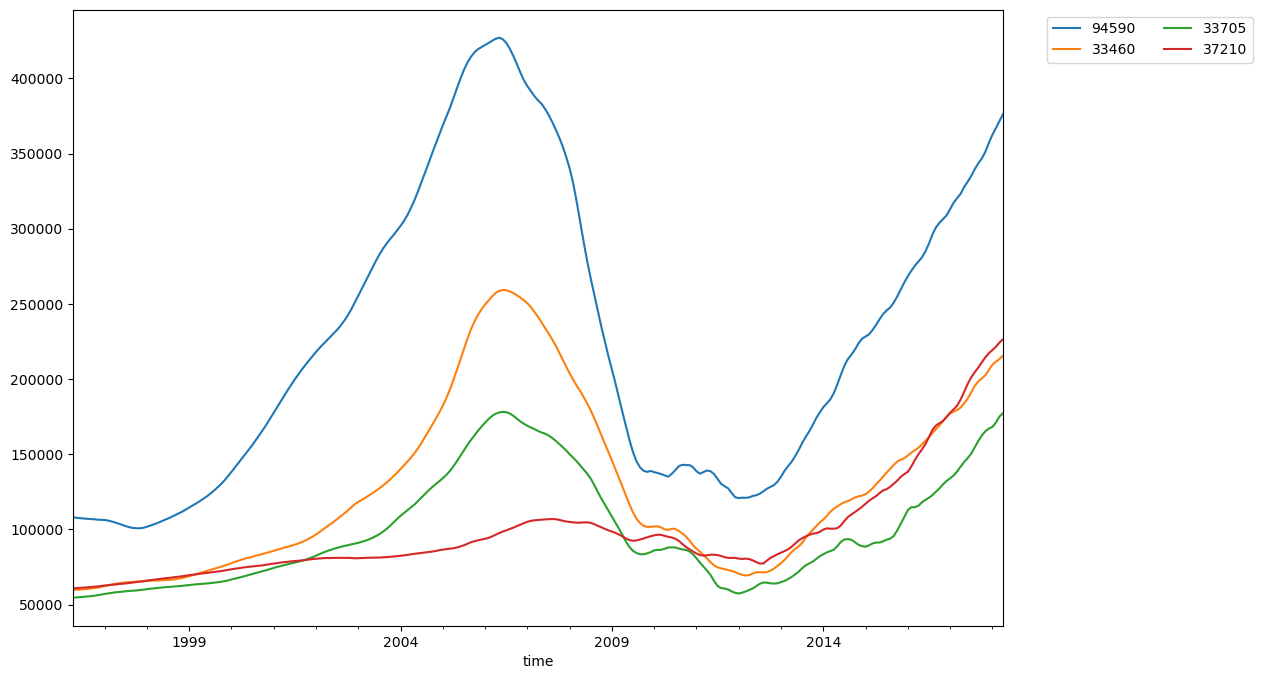

In [19]:
plt.figure(figsize=(12,8))
for zipcode in midzips.ZipCode.unique():
    midzips.loc[midzips['ZipCode'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.show();

In [20]:
mid = midzips.drop(['ZipCode', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], axis=1)
mid

value
time                
1996-04-01  108200.0
1996-04-01   59800.0
1996-04-01   54600.0
1996-04-01   60800.0
1996-05-01  107800.0
...              ...
2018-03-01  224300.0
2018-04-01  376100.0
2018-04-01  215600.0
2018-04-01  177300.0
2018-04-01  226500.0

[1060 rows x 1 columns]

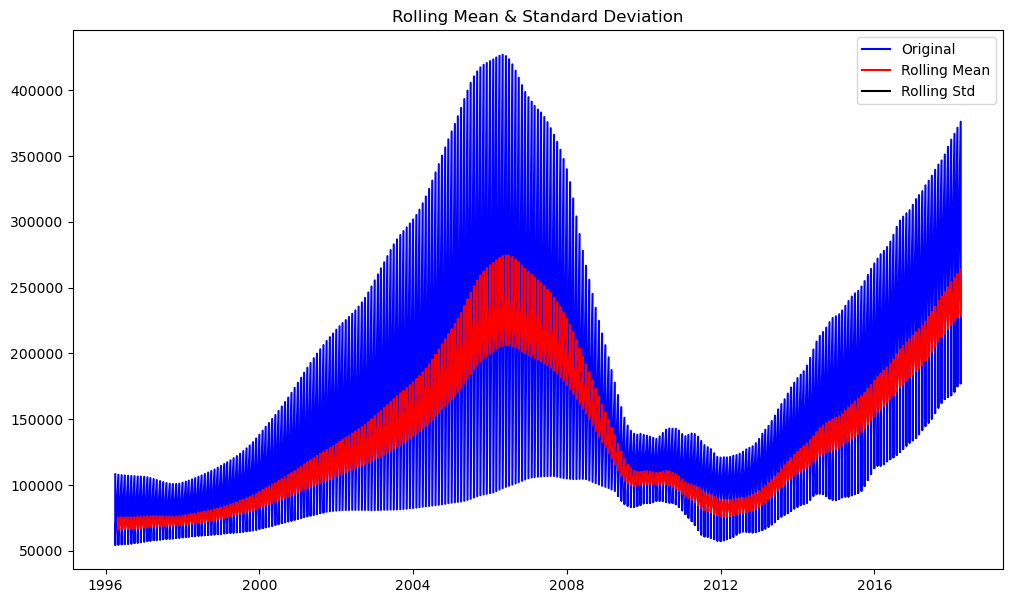

In [21]:
rolmean = mid.rolling(window=6, center=False).mean()
rolstd = mid.rolling(window=1, center=False).std()

fig = plt.figure(figsize=(12, 7))
orig = plt.plot(mid, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Vallejo - Zipcode 94590

In [23]:
Vallejo_94590 = melted[(melted['ZipCode'] == '94590')]
Vallejo_94590 = Vallejo_94590.drop(['ZipCode', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], axis=1)
Vallejo_94590

value
time                
1996-04-01  108200.0
1996-05-01  107800.0
1996-06-01  107500.0
1996-07-01  107300.0
1996-08-01  107100.0
...              ...
2017-12-01  357100.0
2018-01-01  362500.0
2018-02-01  366900.0
2018-03-01  371600.0
2018-04-01  376100.0

[265 rows x 1 columns]

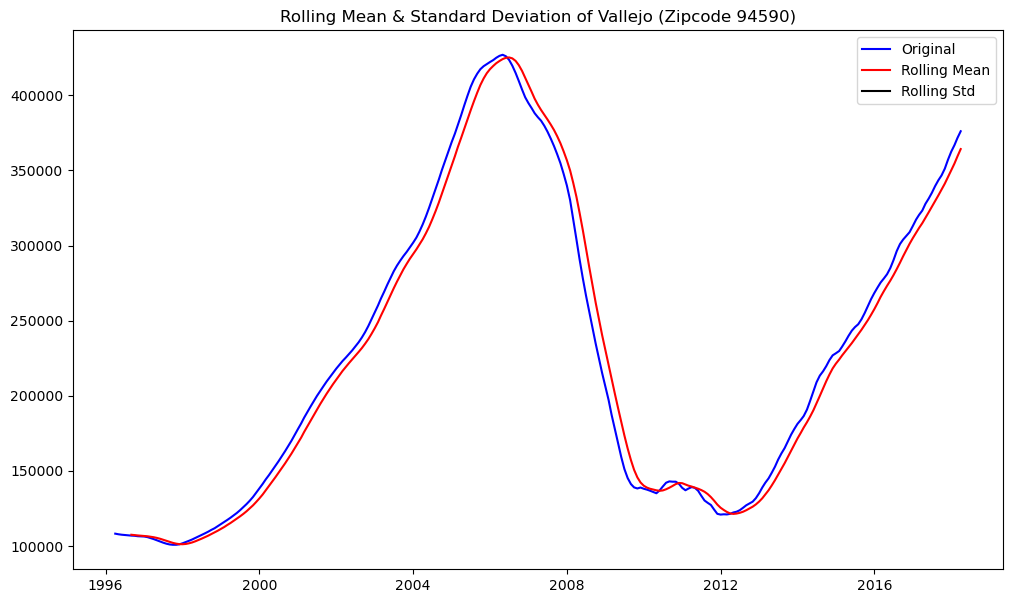

In [29]:
rolmean = Vallejo_94590.rolling(window=6, center=False).mean()
rolstd = Vallejo_94590.rolling(window=1, center=False).std()

fig = plt.figure(figsize=(12, 7))
orig = plt.plot(Vallejo_94590, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation of Vallejo (Zipcode 94590)')
plt.show(block=False)

In [30]:
# Specify the variable of interest
var_col = 'value'  # Replace this with the name of the column you want to analyze

# Reduce the DataFrame down to the relevant columns
df_subset = Vallejo_94590[[var_col]]  # Pass in the column(s) of interest as a list here

# Select the date range you want to explore
df_time = df_subset[
    "2013-04-01":"2018-04-01"  # Pass in the date ranges you are interested in here
].copy()

# Reset the index
df_time.reset_index(inplace=True)

# Preview the DataFrame
df_time

time     value
0  2013-04-01  145000.0
1  2013-05-01  148700.0
2  2013-06-01  152800.0
3  2013-07-01  157500.0
4  2013-08-01  161600.0
..        ...       ...
56 2017-12-01  357100.0
57 2018-01-01  362500.0
58 2018-02-01  366900.0
59 2018-03-01  371600.0
60 2018-04-01  376100.0

[61 rows x 2 columns]

In [31]:
# Use this line to specify the number of periods to shift
shift_periods = 1

# Create a column shifted backward by the number of periods specified above (lag)
df_time["lag_data"] = df_time[var_col].shift(-shift_periods)

# Create a column shifted forward by the number of periods specified above (lead)
df_time["lead_data"] = df_time[var_col].shift(shift_periods)

# Melt the DataFrame in preparation for visualization and drop null values
df_shift = df_time.melt(id_vars="time", var_name="period", value_name="price").dropna()

# Inspect the DataFrame
df_shift

time     period     price
0   2013-04-01      value  145000.0
1   2013-05-01      value  148700.0
2   2013-06-01      value  152800.0
3   2013-07-01      value  157500.0
4   2013-08-01      value  161600.0
..         ...        ...       ...
178 2017-12-01  lead_data  351200.0
179 2018-01-01  lead_data  357100.0
180 2018-02-01  lead_data  362500.0
181 2018-03-01  lead_data  366900.0
182 2018-04-01  lead_data  371600.0

[181 rows x 3 columns]

In [32]:
# Use this line to specify the rate of change you want to calculate
pct_return_periods = 12

# Create a column with the percentage increase and multiply by 100
df_time['percent_change'] = (
    df_time[var_col].pct_change(periods=pct_return_periods).mul(100)
)

# Select relevant columns and drop null values
df_pct = df_time[['time', 'percent_change']].dropna()

# Preview the DataFrame
df_pct

time  percent_change
12 2014-04-01       31.586207
13 2014-05-01       32.212508
14 2014-06-01       32.853403
15 2014-07-01       32.698413
16 2014-08-01       32.054455
17 2014-09-01       30.932203
18 2014-10-01       29.616519
19 2014-11-01       28.546812
20 2014-12-01       27.615298
21 2015-01-01       25.923883
22 2015-02-01       24.959217
23 2015-03-01       24.772118
24 2015-04-01       23.794549
25 2015-05-01       22.024415
26 2015-06-01       19.852217
27 2015-07-01       17.559809
28 2015-08-01       16.026242
29 2015-09-01       15.996301
30 2015-10-01       16.067365
31 2015-11-01       16.041108
32 2015-12-01       16.483032
33 2016-01-01       17.564608
34 2016-02-01       18.407311
35 2016-03-01       18.349807
36 2016-04-01       17.739204
37 2016-05-01       17.090454
38 2016-06-01       17.139334
39 2016-07-01       18.111518
40 2016-08-01       19.668821
41 2016-09-01       19.968115
42 2016-10-01       19.215686
43 2016-11-01       18.020793
44 2016-12-01       16.874764
45 2017-01-01       16.616990
46 2017-02-01       16.611540
47 2017-03-01       16.339869
48 2017-04-01       16.253146
49 2017-05-01       16.696333
50 2017-06-01       16.245614
51 2017-07-01       15.472088
52 2017-08-01       14.613567
53 2017-09-01       14.119601
54 2017-10-01       14.046053
55 2017-11-01       14.584013
56 2017-12-01       15.603755
57 2018-01-01       15.814696
58 2018-02-01       15.631894
59 2018-03-01       15.980025
60 2018-04-01       16.331581

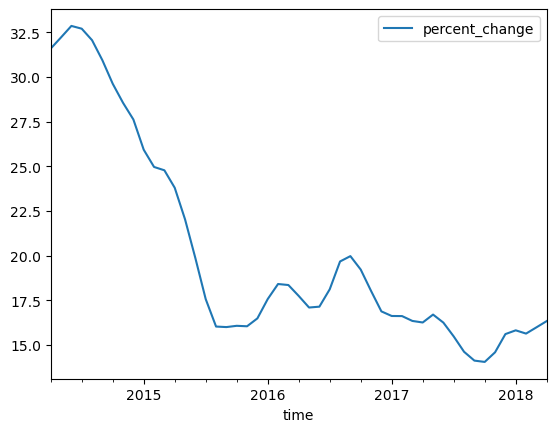

In [33]:
df_pct.plot(x='time', y='percent_change');

In [34]:
midzips

ZipCode  SizeRank              City State                  Metro  \
time                                                                          
1996-04-01   94590      1240           Vallejo    CA                Vallejo   
1996-04-01   33460      2628        Lake Worth    FL  Miami-Fort Lauderdale   
1996-04-01   33705      2662  Saint Petersburg    FL                  Tampa   
1996-04-01   37210      6106         Nashville    TN              Nashville   
1996-05-01   94590      1240           Vallejo    CA                Vallejo   
...            ...       ...               ...   ...                    ...   
2018-03-01   37210      6106         Nashville    TN              Nashville   
2018-04-01   94590      1240           Vallejo    CA                Vallejo   
2018-04-01   33460      2628        Lake Worth    FL  Miami-Fort Lauderdale   
2018-04-01   33705      2662  Saint Petersburg    FL                  Tampa   
2018-04-01   37210      6106         Nashville    TN              Nashville   

            CountyName     value  
time                              
1996-04-01      Solano  108200.0  
1996-04-01  Palm Beach   59800.0  
1996-04-01    Pinellas   54600.0  
1996-04-01    Davidson   60800.0  
1996-05-01      Solano  107800.0  
...                ...       ...  
2018-03-01    Davidson  224300.0  
2018-04-01      Solano  376100.0  
2018-04-01  Palm Beach  215600.0  
2018-04-01    Pinellas  177300.0  
2018-04-01    Davidson  226500.0  

[1060 rows x 7 columns]

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_zipcode_pct_change(df, zipcode_col, var_col, start_date, end_date, pct_return_periods):
    """
    Plot the percentage change for each zipcode in the specified date range.
    
    Parameters:
        - data (pandas DataFrame): The dataset to analyze
        - zipcode_col (str): The name of the column containing the zipcodes
        - var_col (str): The name of the column containing the variable of interest
        - start_date (str): The start date of the date range to analyze (YYYY-MM-DD format)
        - end_date (str): The end date of the date range to analyze (YYYY-MM-DD format)
        - pct_return_periods (int): The number of periods to calculate the percentage change over
        
    Returns:
        - None (plots the data)
    """
    # Create a single subplot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Loop through each zipcode
    for zipcode in df[zipcode_col].unique():
        # Reduce the DataFrame down to the relevant columns and zipcode
        df_zipcode = df[df[zipcode_col] == zipcode][[var_col]]
        
        # Select the date range you want to explore
        df_time = df_zipcode[start_date:end_date].copy()
        
        # Reset the index
        df_time.reset_index(inplace=True)
        
        # Create a column with the percentage increase and multiply by 100
        df_time['percent_change'] = (
            df_time[var_col].pct_change(periods=pct_return_periods).mul(100)
        )
        
        # Select relevant columns and drop null values
        df_pct = df_time[['time', 'percent_change']].dropna()
        
        # Plot the percentage change for this zipcode
        ax.plot(df_pct['time'], df_pct['percent_change'], label=f"Zipcode {zipcode}")
    
    # Set the title and labels
    ax.set_title("Percentage Change for the Top 10 Zip Codes with 5% Returns")
    ax.set_xlabel("Time")
    ax.set_ylabel("Percent Change")
    
    # Add a legend
    ax.legend()
    ax.legend(fontsize='xx-small')
    plt.legend(loc="upper right", ncol=2)
    
    # Show the plot
    plt.show()


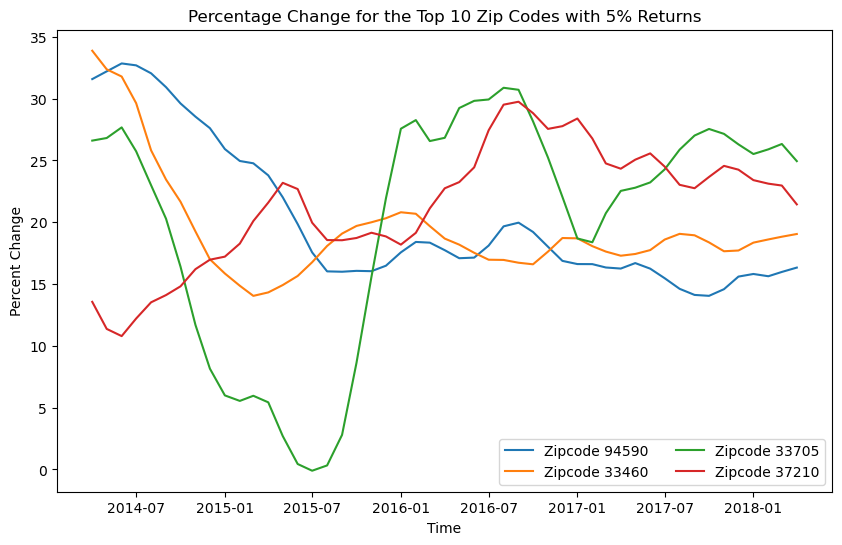

In [53]:
plot_zipcode_pct_change(midzips, 'ZipCode', 'value', '2013-04-01', '2018-04-01', 12)

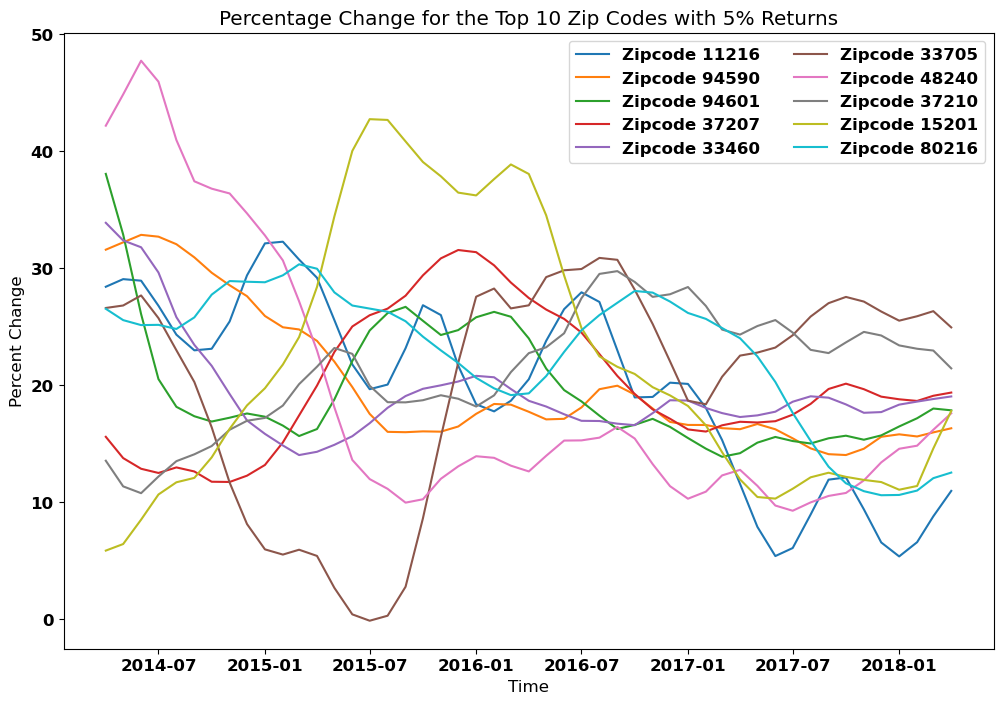

In [75]:
plot_zipcode_pct_change(top10_5YRreturn, 'ZipCode', 'value', '2013-04-01', '2018-04-01', 12)

### Top 10 Zips

In [37]:
top10_5YRreturn = melted[(melted['ZipCode'] == '80216') |
                         (melted['ZipCode'] == '94601') |
                         (melted['ZipCode'] == '48240') |
                         (melted['ZipCode'] == '94590') |
                         (melted['ZipCode'] == '33705') |
                         (melted['ZipCode'] == '37210') |
                         (melted['ZipCode'] == '33460') |
                         (melted['ZipCode'] == '15201') |
                         (melted['ZipCode'] == '11216') |
                         (melted['ZipCode'] == '37207')]
                         
top10_5YRreturn

ZipCode  SizeRank              City State                  Metro  \
time                                                                          
1996-04-01   11216       476          New York    NY               New York   
1996-04-01   94590      1240           Vallejo    CA                Vallejo   
1996-04-01   94601      1478           Oakland    CA          San Francisco   
1996-04-01   37207      1836         Nashville    TN              Nashville   
1996-04-01   33460      2628        Lake Worth    FL  Miami-Fort Lauderdale   
...            ...       ...               ...   ...                    ...   
2018-04-01   33705      2662  Saint Petersburg    FL                  Tampa   
2018-04-01   48240      5831           Redford    MI                Detroit   
2018-04-01   37210      6106         Nashville    TN              Nashville   
2018-04-01   15201      6564        Pittsburgh    PA             Pittsburgh   
2018-04-01   80216      7303            Denver    CO                 Denver   

            CountyName     value  
time                              
1996-04-01       Kings  146100.0  
1996-04-01      Solano  108200.0  
1996-04-01     Alameda  114600.0  
1996-04-01    Davidson   63600.0  
1996-04-01  Palm Beach   59800.0  
...                ...       ...  
2018-04-01    Pinellas  177300.0  
2018-04-01       Wayne   76800.0  
2018-04-01    Davidson  226500.0  
2018-04-01   Allegheny  185200.0  
2018-04-01      Denver  267300.0  

[2449 rows x 7 columns]

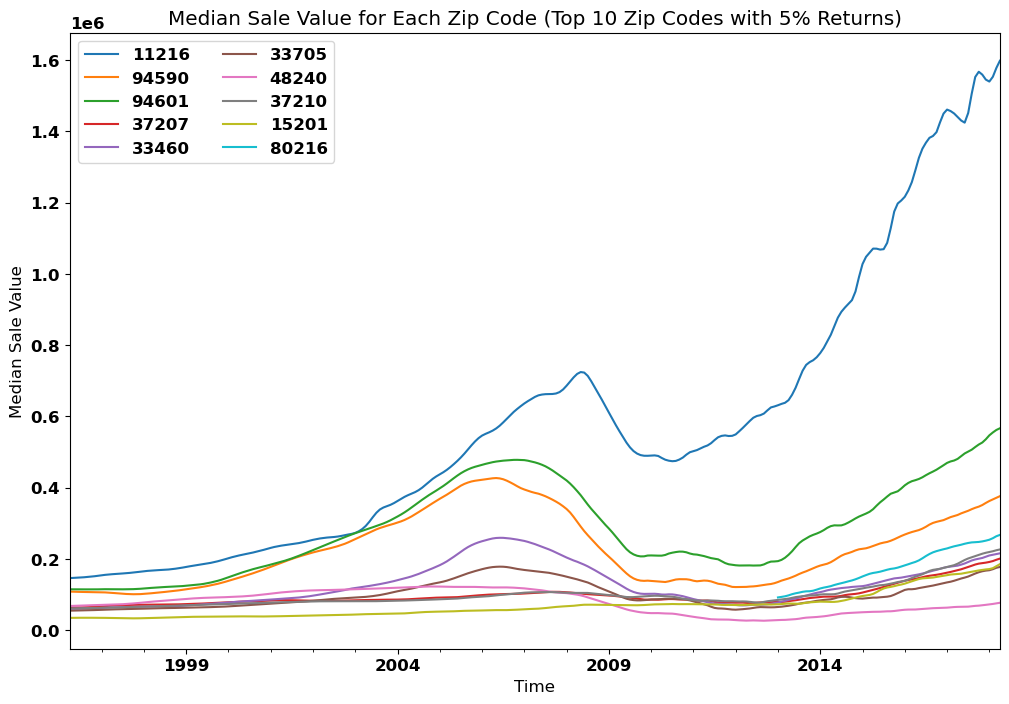

In [78]:
fig, ax = plt.subplots(figsize=(12, 8))
for zipcode in top10_5YRreturn.ZipCode.unique():
    top10_5YRreturn.loc[top10_5YRreturn['ZipCode'] == zipcode].value.plot(label=zipcode)
plt.legend(loc="upper left", ncol=2)

# Set the title and labels
ax.set_title("Median Sale Value for Each Zip Code (Top 10 Zip Codes with 5% Returns)")
ax.set_xlabel("Time")
ax.set_ylabel("Median Sale Value")
plt.show();

In [33]:
top = top10_5YRreturn.drop(['ZipCode', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], axis=1)
top

value
time                
1996-04-01  146100.0
1996-04-01  108200.0
1996-04-01  114600.0
1996-04-01   63600.0
1996-04-01   59800.0
...              ...
2018-04-01  177300.0
2018-04-01   76800.0
2018-04-01  226500.0
2018-04-01  185200.0
2018-04-01  267300.0

[2449 rows x 1 columns]

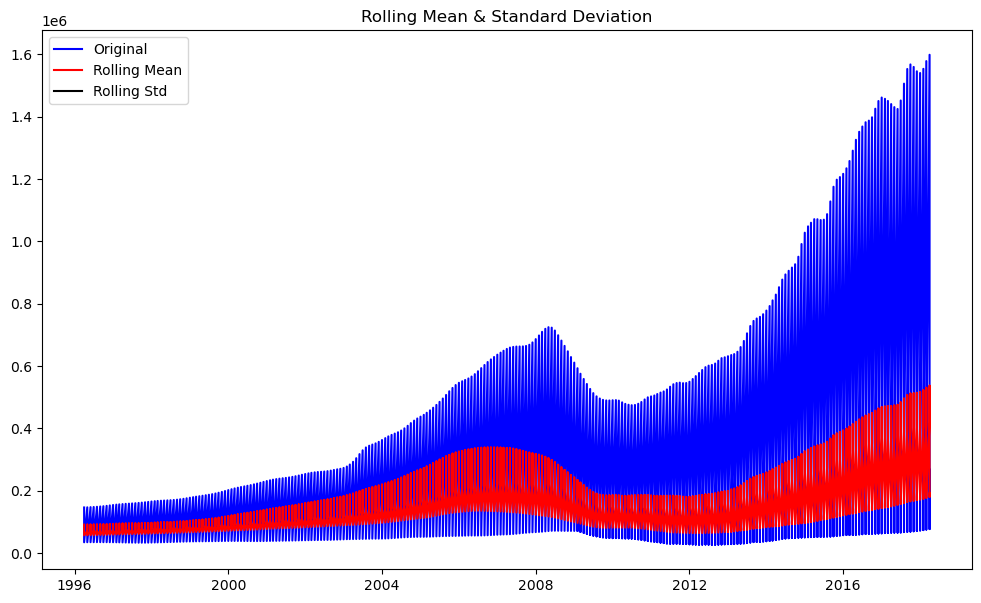

In [34]:
rolmean = top.rolling(window=6, center=False).mean()
rolstd = top.rolling(window=1, center=False).std()

fig = plt.figure(figsize=(12, 7))
orig = plt.plot(top, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [35]:
test = adfuller(top)
test

(0.043495257574431755,
 0.9619846720470889,
 27,
 2421,
 {'1%': -3.433053943432798,
  '5%': -2.8627345707126906,
  '10%': -2.56740591915091},
 52566.645455417)

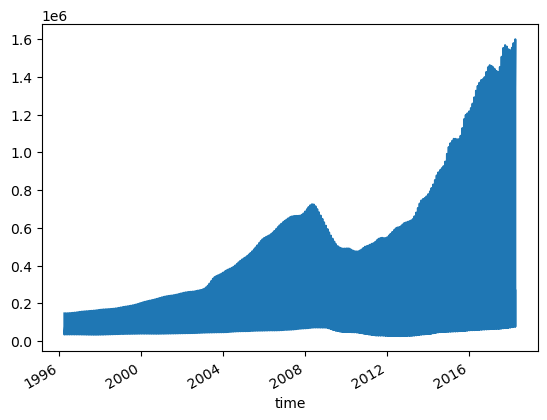

In [36]:
top10_5YRreturn['value'].plot();

In [37]:
top10_5YRreturn

ZipCode  SizeRank              City State                  Metro  \
time                                                                          
1996-04-01   11216       476          New York    NY               New York   
1996-04-01   94590      1240           Vallejo    CA                Vallejo   
1996-04-01   94601      1478           Oakland    CA          San Francisco   
1996-04-01   37207      1836         Nashville    TN              Nashville   
1996-04-01   33460      2628        Lake Worth    FL  Miami-Fort Lauderdale   
...            ...       ...               ...   ...                    ...   
2018-04-01   33705      2662  Saint Petersburg    FL                  Tampa   
2018-04-01   48240      5831           Redford    MI                Detroit   
2018-04-01   37210      6106         Nashville    TN              Nashville   
2018-04-01   15201      6564        Pittsburgh    PA             Pittsburgh   
2018-04-01   80216      7303            Denver    CO                 Denver   

            CountyName     value  
time                              
1996-04-01       Kings  146100.0  
1996-04-01      Solano  108200.0  
1996-04-01     Alameda  114600.0  
1996-04-01    Davidson   63600.0  
1996-04-01  Palm Beach   59800.0  
...                ...       ...  
2018-04-01    Pinellas  177300.0  
2018-04-01       Wayne   76800.0  
2018-04-01    Davidson  226500.0  
2018-04-01   Allegheny  185200.0  
2018-04-01      Denver  267300.0  

[2449 rows x 7 columns]

In [38]:
top10_5YRreturn['ZipCode'].nunique()


10

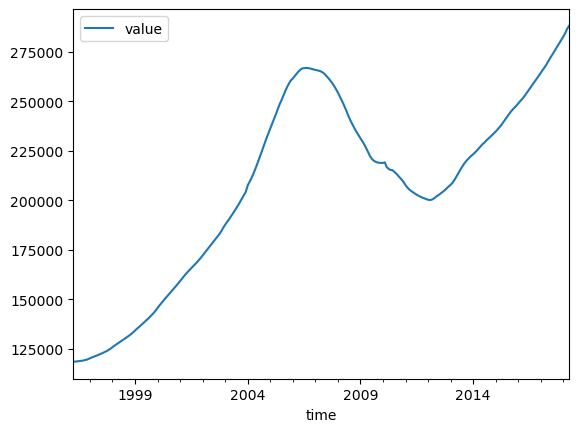

In [39]:
ts.plot();

In [41]:
# Specify the variable of interest
var_col = 'value'  # Replace this with the name of the column you want to analyze

# Reduce the DataFrame down to the relevant columns
df_subset = top10_5YRreturn[[var_col]]  # Pass in the column(s) of interest as a list here

# Select the date range you want to explore
df_time = df_subset[
    "2013-04-01":"2018-04-01"  # Pass in the date ranges you are interested in here
].copy()

# Reset the index
df_time.reset_index(inplace=True)

# Preview the DataFrame
df_time

time     value
0   2013-04-01  645700.0
1   2013-04-01  145000.0
2   2013-04-01  211500.0
3   2013-04-01   81400.0
4   2013-04-01   85000.0
..         ...       ...
605 2018-04-01  177300.0
606 2018-04-01   76800.0
607 2018-04-01  226500.0
608 2018-04-01  185200.0
609 2018-04-01  267300.0

[610 rows x 2 columns]

In [42]:
# Use this line to specify the number of periods to shift
shift_periods = 1

# Create a column shifted backward by the number of periods specified above (lag)
df_time["lag_data"] = df_time[var_col].shift(-shift_periods)

# Create a column shifted forward by the number of periods specified above (lead)
df_time["lead_data"] = df_time[var_col].shift(shift_periods)

# Melt the DataFrame in preparation for visualization and drop null values
df_shift = df_time.melt(id_vars="time", var_name="period", value_name="price").dropna()

# Inspect the DataFrame
df_shift

time     period     price
0    2013-04-01      value  645700.0
1    2013-04-01      value  145000.0
2    2013-04-01      value  211500.0
3    2013-04-01      value   81400.0
4    2013-04-01      value   85000.0
...         ...        ...       ...
1825 2018-04-01  lead_data  215600.0
1826 2018-04-01  lead_data  177300.0
1827 2018-04-01  lead_data   76800.0
1828 2018-04-01  lead_data  226500.0
1829 2018-04-01  lead_data  185200.0

[1828 rows x 3 columns]

In [43]:
# Use this line to specify the rate of change you want to calculate
pct_return_periods = 12

# Create a column with the percentage increase and multiply by 100
df_time['percent_change'] = (
    df_time[var_col].pct_change(periods=pct_return_periods).mul(100)
)

# Select relevant columns and drop null values
df_pct = df_time[['time', 'percent_change']].dropna()

# Preview the DataFrame
df_pct

time  percent_change
12  2013-05-01      -65.711631
13  2013-05-01      -42.965517
14  2013-05-01      -58.817967
15  2013-05-01      -13.882064
16  2013-05-01      -64.588235
..         ...             ...
605 2018-04-01      -10.273279
606 2018-04-01      -63.994374
607 2018-04-01       29.354654
608 2018-04-01      145.949535
609 2018-04-01       19.170753

[598 rows x 2 columns]

<Figure size 1200x600 with 0 Axes>

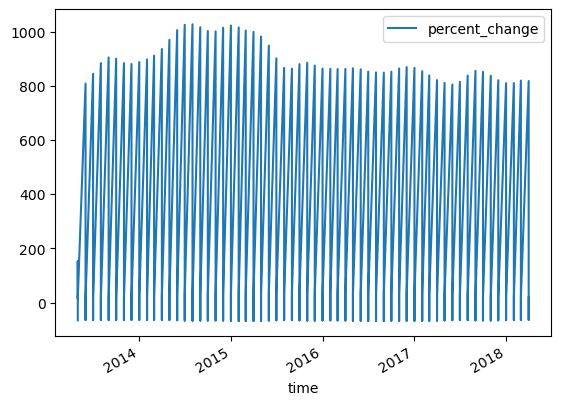

In [44]:
fig = plt.figure(figsize=(12, 6))

df_pct.plot(x='time', y='percent_change');


In [45]:
# Use this line to specify the size of the window you wish to use
window = 30  # Specify your chosen window here

# Create a column with a moving average using the window specified above
df_time["moving_average"] = df_time[var_col].rolling(window).mean()

# Create a column with an expanding average over all previous rows
df_time["expanding_average"] = df_time[var_col].expanding().mean()

# Select relevant columns and melt the DataFrame
df_window = df_time[["time", var_col, "moving_average", "expanding_average"]].\
	melt(id_vars="time", var_name="period", value_name="price")

# Drop null values
df_window.dropna(inplace=True)

# Preview the DataFrame
df_window

time             period          price
0    2013-04-01              value  645700.000000
1    2013-04-01              value  145000.000000
2    2013-04-01              value  211500.000000
3    2013-04-01              value   81400.000000
4    2013-04-01              value   85000.000000
...         ...                ...            ...
1825 2018-04-01  expanding_average  269334.158416
1826 2018-04-01  expanding_average  269016.968699
1827 2018-04-01  expanding_average  268947.039474
1828 2018-04-01  expanding_average  268809.523810
1829 2018-04-01  expanding_average  268807.049180

[1801 rows x 3 columns]

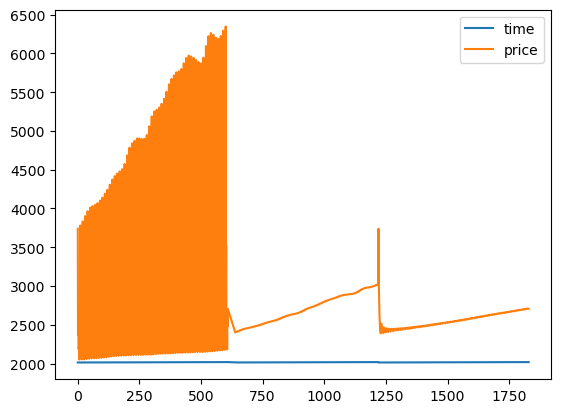

In [46]:
df_window.plot();

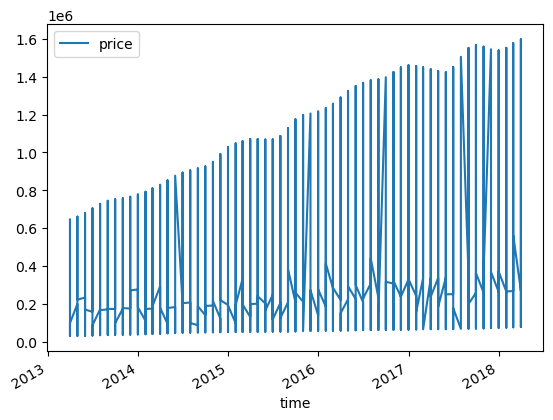

In [47]:
df_window.plot(x='time', y='price');

In [48]:
top10_5YRreturn

ZipCode  SizeRank              City State                  Metro  \
time                                                                          
1996-04-01   11216       476          New York    NY               New York   
1996-04-01   94590      1240           Vallejo    CA                Vallejo   
1996-04-01   94601      1478           Oakland    CA          San Francisco   
1996-04-01   37207      1836         Nashville    TN              Nashville   
1996-04-01   33460      2628        Lake Worth    FL  Miami-Fort Lauderdale   
...            ...       ...               ...   ...                    ...   
2018-04-01   33705      2662  Saint Petersburg    FL                  Tampa   
2018-04-01   48240      5831           Redford    MI                Detroit   
2018-04-01   37210      6106         Nashville    TN              Nashville   
2018-04-01   15201      6564        Pittsburgh    PA             Pittsburgh   
2018-04-01   80216      7303            Denver    CO                 Denver   

            CountyName     value  
time                              
1996-04-01       Kings  146100.0  
1996-04-01      Solano  108200.0  
1996-04-01     Alameda  114600.0  
1996-04-01    Davidson   63600.0  
1996-04-01  Palm Beach   59800.0  
...                ...       ...  
2018-04-01    Pinellas  177300.0  
2018-04-01       Wayne   76800.0  
2018-04-01    Davidson  226500.0  
2018-04-01   Allegheny  185200.0  
2018-04-01      Denver  267300.0  

[2449 rows x 7 columns]

In [49]:
def plot_zipcode_data(df, zipcode_col, value_col, window):
    """
    Plots the original, rolling mean, and rolling standard deviation lines for each zipcode in the given dataset.
    
    Parameters:
    data (pandas.DataFrame): The dataset containing Zipcode and value columns with time as the index.
    zipcode_col (str): The name of the column containing the zipcodes.
    value_col (str): The name of the column containing the values to plot.
    window (int): The size of the rolling window used to calculate the rolling mean and standard deviation.
    """
    #Initialize an empty list to store the plots
    plots = []
    
    #Group the data by zipcode
    grouped = df.groupby(zipcode_col)
    
    #Loop over each group
    for name, group in grouped:
        #Calculate the rolling mean and standard deviation
        group['rolling_mean'] = group[value_col].rolling(window=window).mean()
        group['rolling_std'] = group[value_col].rolling(window=window).std()
        
        #Plot the original, mean, and standard deviation lines for this group
        fig, ax = plt.subplots()
        group[value_col].plot(ax=ax, label='Original')
        group['rolling_mean'].plot(ax=ax, label='Rolling Mean')
        group['rolling_std'].plot(ax=ax, label='Rolling Standard Deviation')
        ax.set_title(f"Zipcode {name}")
        ax.legend()
        
        #Add the plot to the list of plots
        plots.append(fig)
        
        #Add legend
        plt.legend(fontsize="small")
    
    #Show all of the plots
    plt.show();

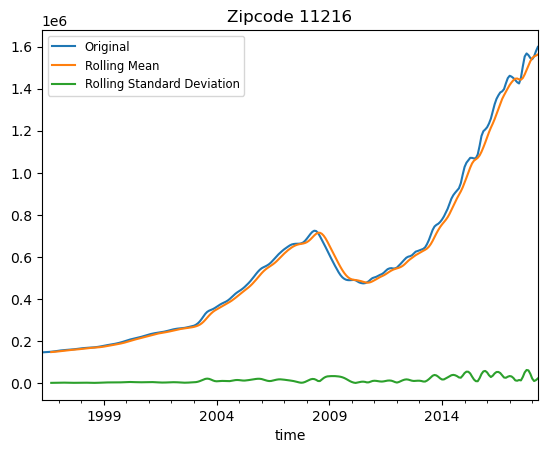

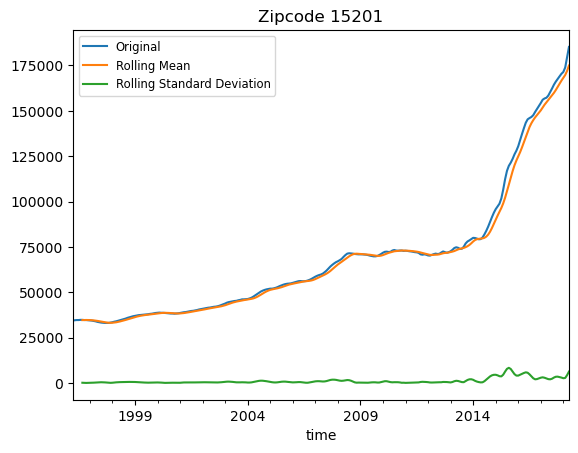

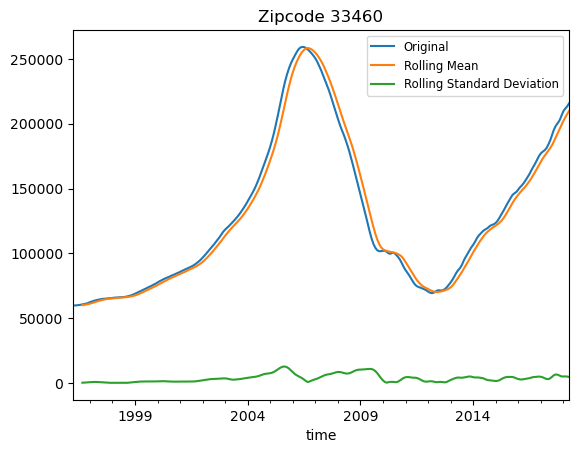

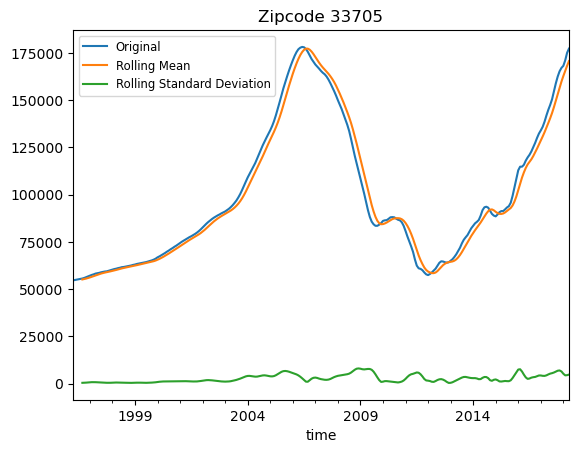

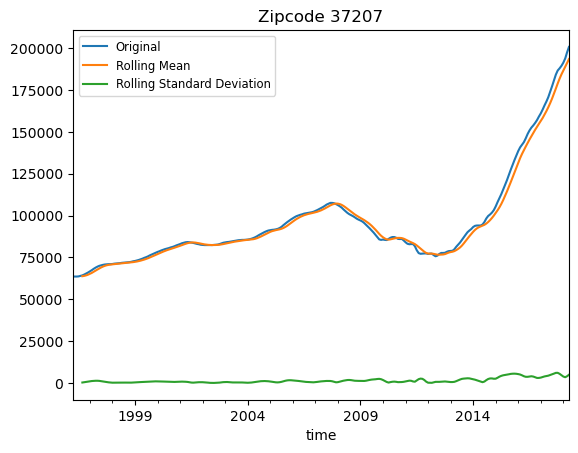

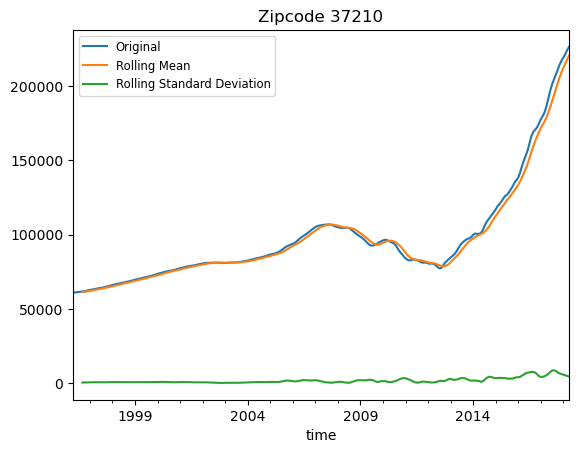

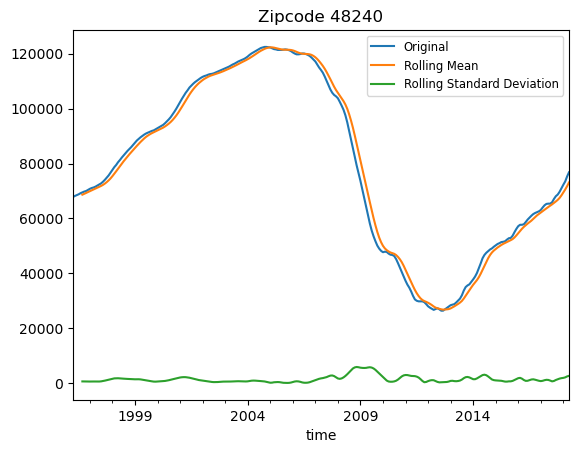

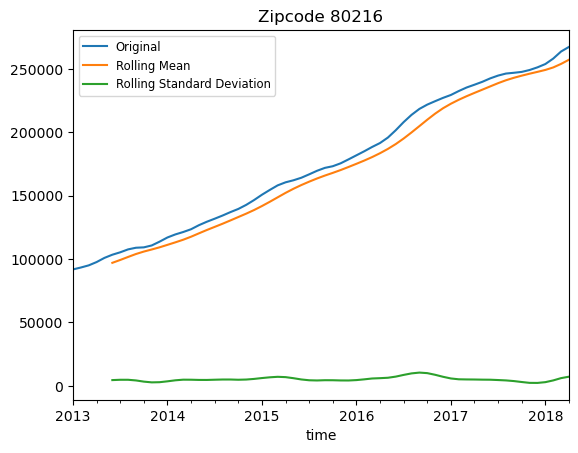

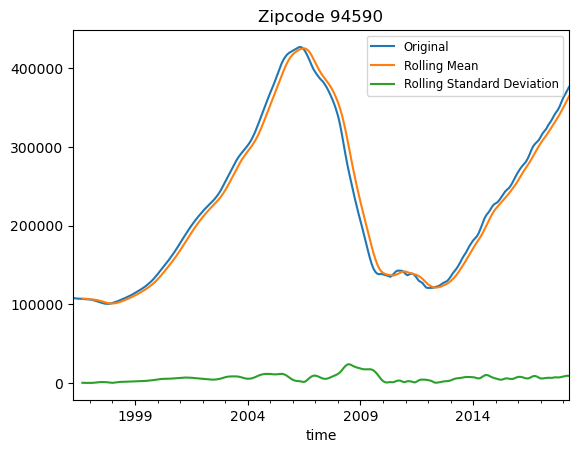

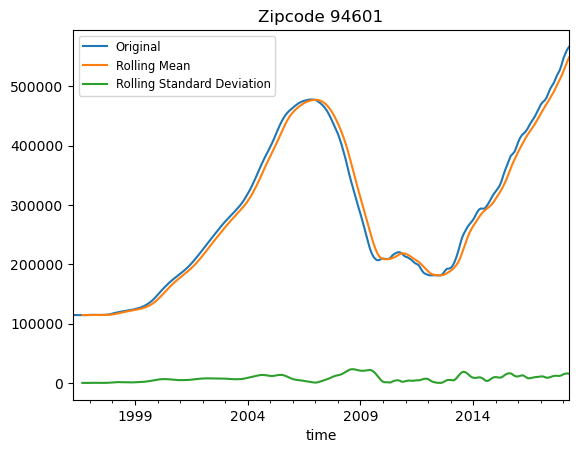

In [50]:
plot_zipcode_data(top10_5YRreturn, 'ZipCode', 'value', 6)

In [51]:
top10_5YRreturn

ZipCode  SizeRank              City State                  Metro  \
time                                                                          
1996-04-01   11216       476          New York    NY               New York   
1996-04-01   94590      1240           Vallejo    CA                Vallejo   
1996-04-01   94601      1478           Oakland    CA          San Francisco   
1996-04-01   37207      1836         Nashville    TN              Nashville   
1996-04-01   33460      2628        Lake Worth    FL  Miami-Fort Lauderdale   
...            ...       ...               ...   ...                    ...   
2018-04-01   33705      2662  Saint Petersburg    FL                  Tampa   
2018-04-01   48240      5831           Redford    MI                Detroit   
2018-04-01   37210      6106         Nashville    TN              Nashville   
2018-04-01   15201      6564        Pittsburgh    PA             Pittsburgh   
2018-04-01   80216      7303            Denver    CO                 Denver   

            CountyName     value  
time                              
1996-04-01       Kings  146100.0  
1996-04-01      Solano  108200.0  
1996-04-01     Alameda  114600.0  
1996-04-01    Davidson   63600.0  
1996-04-01  Palm Beach   59800.0  
...                ...       ...  
2018-04-01    Pinellas  177300.0  
2018-04-01       Wayne   76800.0  
2018-04-01    Davidson  226500.0  
2018-04-01   Allegheny  185200.0  
2018-04-01      Denver  267300.0  

[2449 rows x 7 columns]

In [52]:
top10s = top10_5YRreturn.drop(['SizeRank', 'City', 'State', 'Metro', 'CountyName'], axis=1)
top10s = top10s.sort_values(by='value', ascending=False)[:10]
top10s = top10s.set_index('ZipCode')

top10s

value
ZipCode           
11216    1598700.0
11216    1578400.0
11216    1567700.0
11216    1559700.0
11216    1553600.0
11216    1553100.0
11216    1545700.0
11216    1540200.0
11216    1506100.0
11216    1461500.0

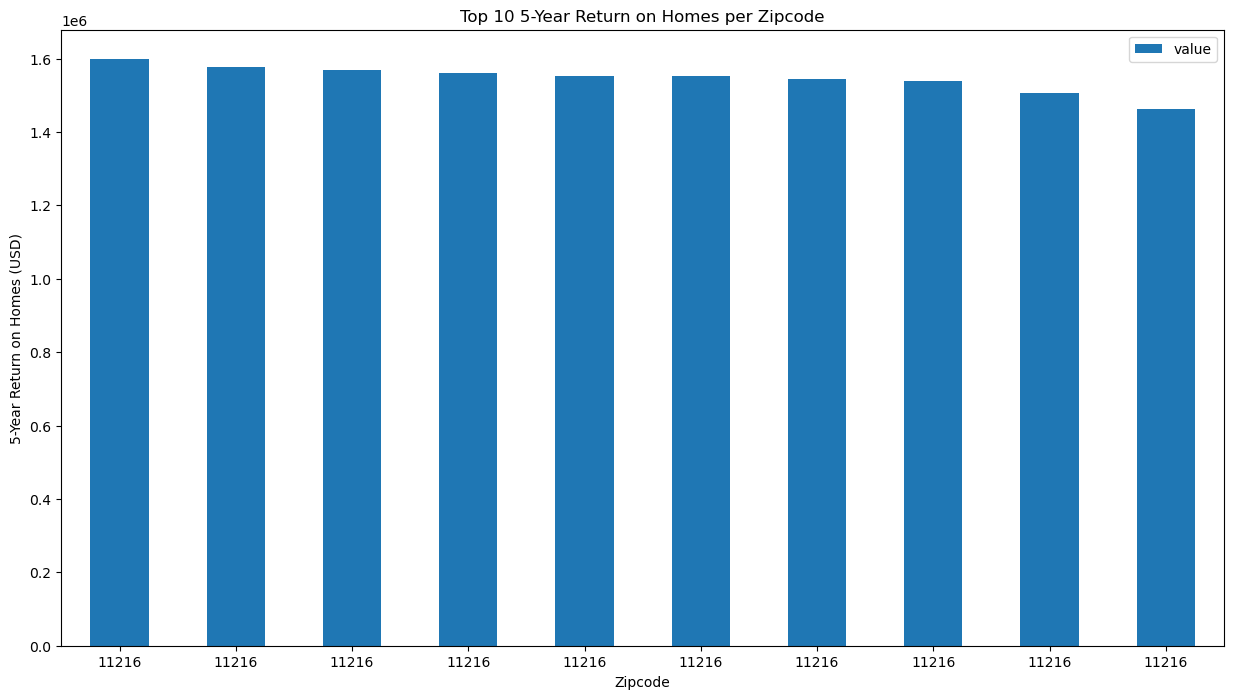

In [53]:
top10s.plot(kind='bar',figsize=(15,8))
plt.title("Top 10 5-Year Return on Homes per Zipcode")
plt.xlabel("Zipcode")
plt.ylabel("5-Year Return on Homes (USD)")
plt.xticks(rotation=0)

plt.plot();

# Step 3: EDA and Visualization

In [66]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

Let's see the median housing sales values of homes within the entire dataset.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


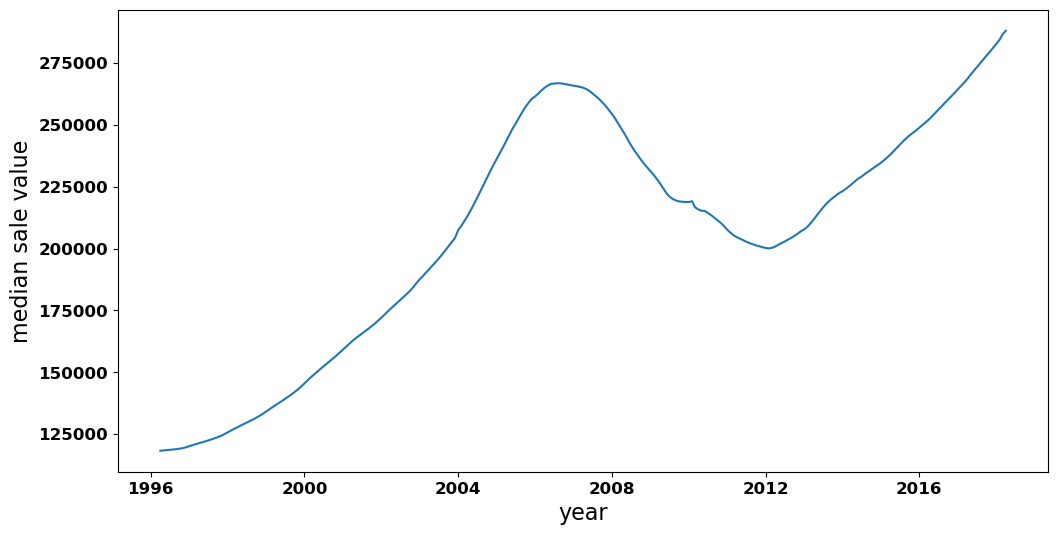

In [55]:
fig = plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.xlabel("year", fontsize=16)
plt.ylabel("median sale value", fontsize=16)
plt.show();

In [56]:
fig = px.choropleth(top10_5YRreturn,
                    locations='State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='value',
                    color_continuous_scale="Viridis_r",      
                    )
fig.update_layout(
      title_text = 'Mean Home Value by State, 1996 - 2018',
      title_font_family="Arial",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )
fig.show()

# Step 5: ARIMA Modeling

In [57]:
Vallejo_94590

value
time                
1996-04-01  108200.0
1996-05-01  107800.0
1996-06-01  107500.0
1996-07-01  107300.0
1996-08-01  107100.0
...              ...
2017-12-01  357100.0
2018-01-01  362500.0
2018-02-01  366900.0
2018-03-01  371600.0
2018-04-01  376100.0

[265 rows x 1 columns]

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


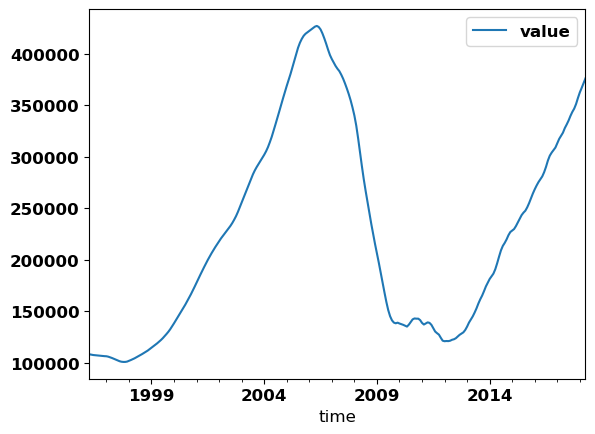

In [58]:
Vallejo_94590.plot();

In [59]:
vtest = adfuller(Vallejo_94590)
vtest

(-2.6283654896767104,
 0.08727525604042469,
 13,
 251,
 {'1%': -3.4566744514553016,
  '5%': -2.8731248767783426,
  '10%': -2.5729436702592023},
 3911.936266830458)

In [60]:
p_val = adfuller(Vallejo_94590)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" therefore we can safely assume that the differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.08727525604042469,
 therefore we cannot reject the null hypothesis that the differenced data is not stationary.


### Stationarity
#### Seasonal Decomposition

In [61]:
# Using log transformation as it decreased the p-value the most of the previous transformations
decomposition = seasonal_decompose(np.sqrt(Vallejo_94590))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

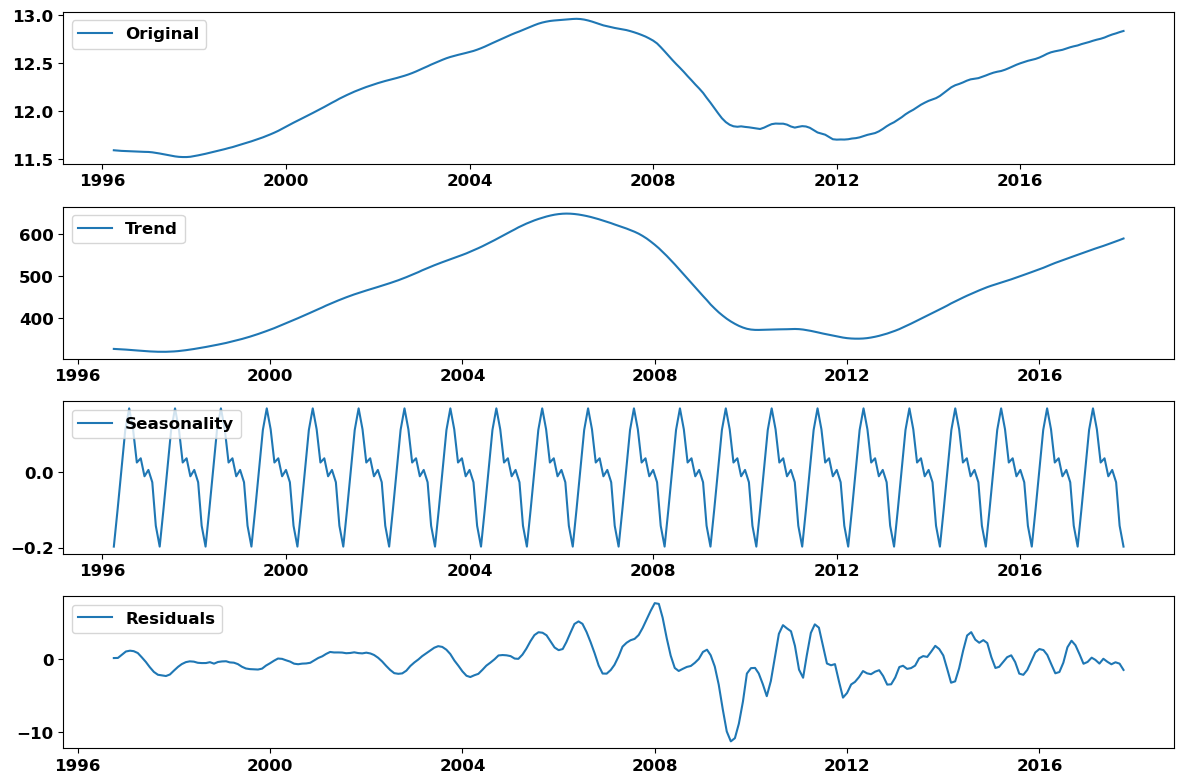

In [62]:
# Plot gathered statistics
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(np.log(Vallejo_94590), label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
plt.tight_layout()

In [63]:
# Drop NaN values from residuals.
v_sdecomp = residual
v_sdecomp = v_sdecomp.dropna()

In [64]:
#Differenced Seasonal Component Transformation

dftest = adfuller(v_sdecomp)[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {dftest},")
if dftest < 0.05:
    print(" therefore we can safely assume that the seasonally differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the seasonally differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.0022601506871529555,
 therefore we can safely assume that the seasonally differenced data is stationary.


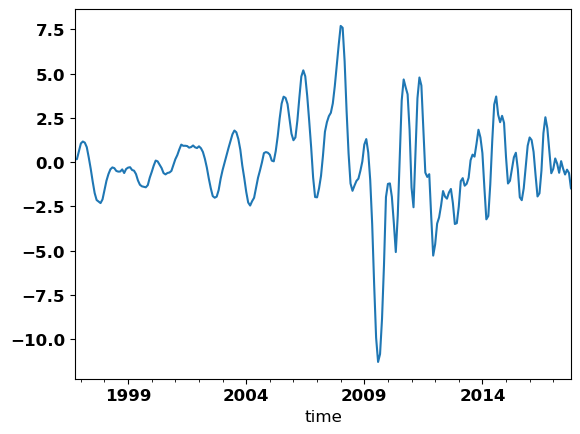

In [65]:
v_sdecomp.plot();

In [66]:
v_sdecomp.var()

6.285371289216267

### Differencing

In [67]:
diff = Vallejo_94590.diff().dropna()

In [68]:
rm_test = adfuller(diff)[1]

print(f"The p-value associated with the Dickey-Fuller statistical test is {rm_test},")
if rm_test < 0.05:
    print(" therefore we can safely assume that subtracted rolling mean data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that subtracted rolling mean data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.2774900844595135,
 therefore we cannot reject the null hypothesis that subtracted rolling mean data is not stationary.


In [69]:
diff2 = diff.diff().dropna()

In [70]:
rm_test = adfuller(diff2)[1]

print(f"The p-value associated with the Dickey-Fuller statistical test is {rm_test},")
if rm_test < 0.05:
    print(" therefore we can safely assume that the twice differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the twice differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.0002528006674008984,
 therefore we can safely assume that the twice differenced data is stationary.


In [71]:
from scipy.stats import levene


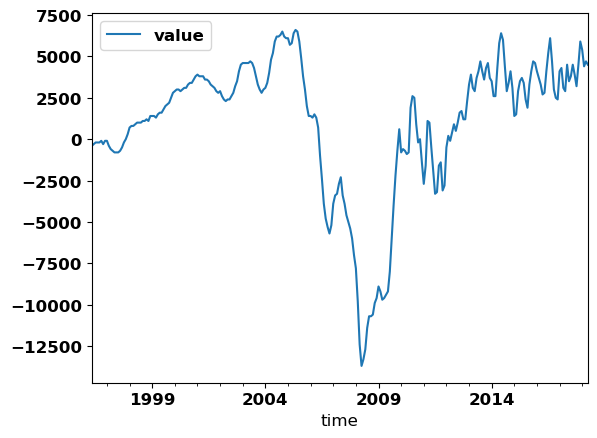

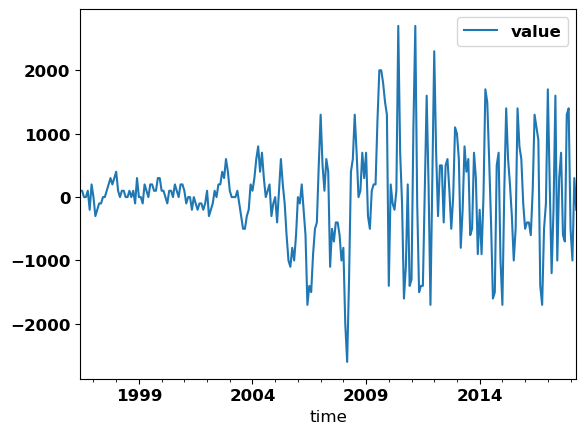

In [72]:
diff.plot();
diff2.plot();

#### Train Test Split

In [73]:
# find the index which allows us to split off 20% of the data
cutoff = round(diff2.shape[0]*0.8) #cut off point at 80% of the data
cutoff

210

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


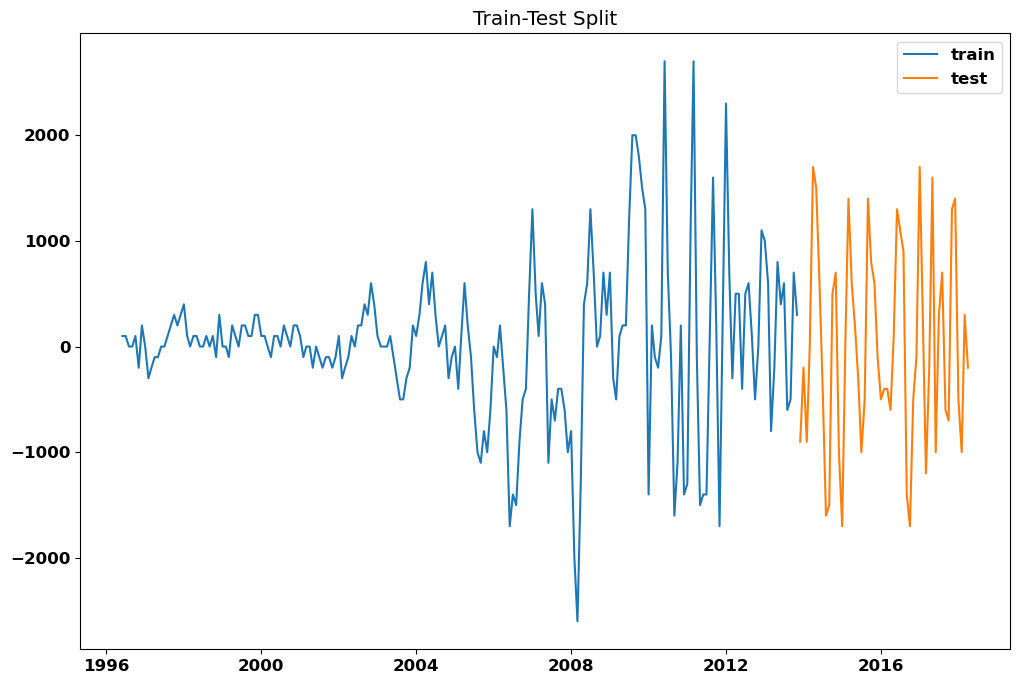

In [74]:
# Define train and test sets according to the index found above
train = diff2[:cutoff] #before cut off is train set -- 80%

test = diff2[cutoff:] #after cut off is the test set --20%

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

### Baseline

In [75]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
naive = train.shift(1)
naive

value
time             
1996-06-01    NaN
1996-07-01  100.0
1996-08-01  100.0
1996-09-01    0.0
1996-10-01    0.0
...           ...
2013-07-01  400.0
2013-08-01  600.0
2013-09-01 -600.0
2013-10-01 -500.0
2013-11-01  700.0

[210 rows x 1 columns]

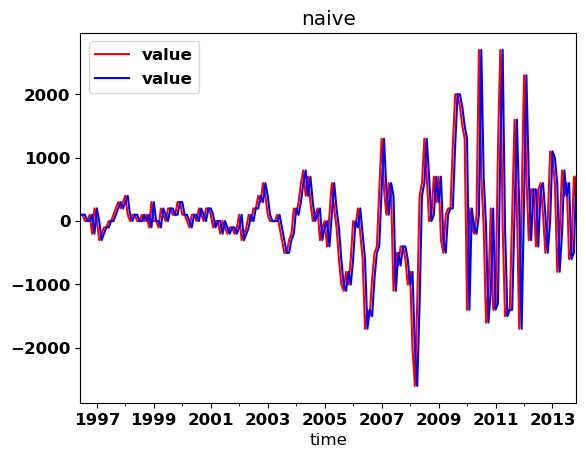

In [76]:
fig, ax = plt.subplots()

train.plot(ax=ax, c='r', label='original')
naive.plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

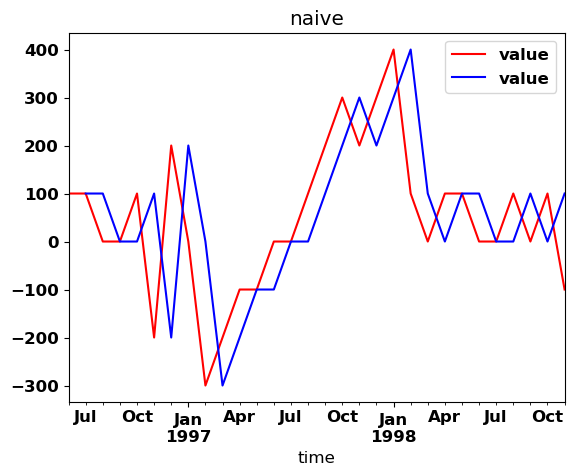

In [77]:
#A closer look
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [78]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

705.2095959093859

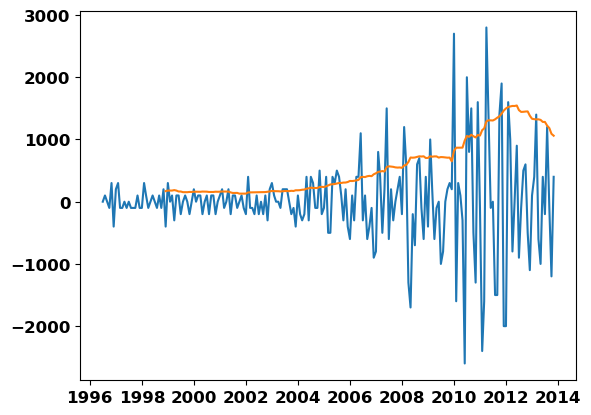

In [79]:
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:] #shift minus the train
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

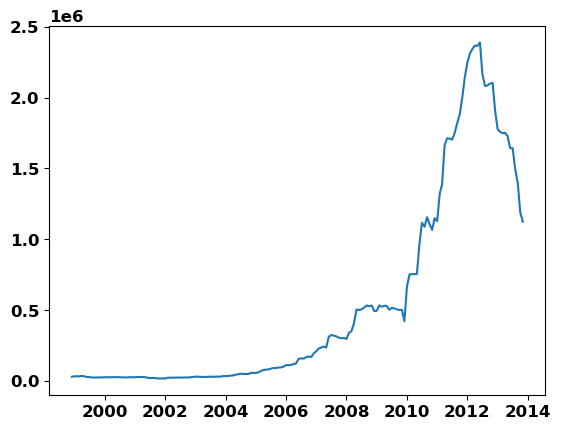

In [80]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

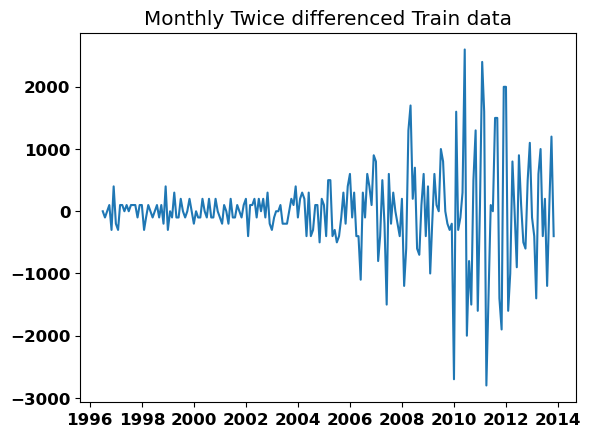

In [81]:
fig, ax = plt.subplots()
ax.plot(train.diff())  #taking the differnce
ax.set_title('Monthly Twice differenced Train data');

In [82]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" therefore we can safely assume that the differenced data is stationary.")
else:
    print(" therefore we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 5.43336685861857e-16,
 therefore we can safely assume that the differenced data is stationary.


#### ARIMA

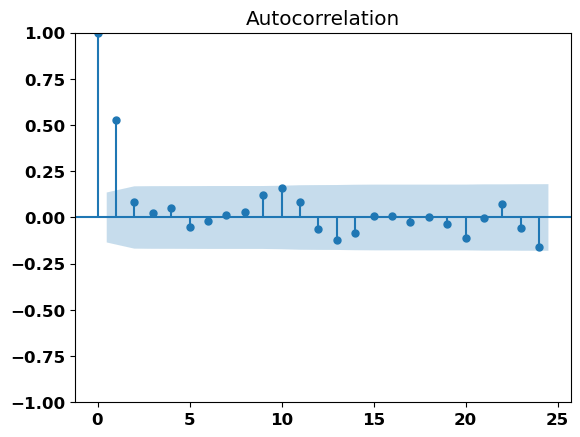

In [83]:
#Plot_acf is used to identify the q parameter
plot_acf(train);

check q -- 2

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



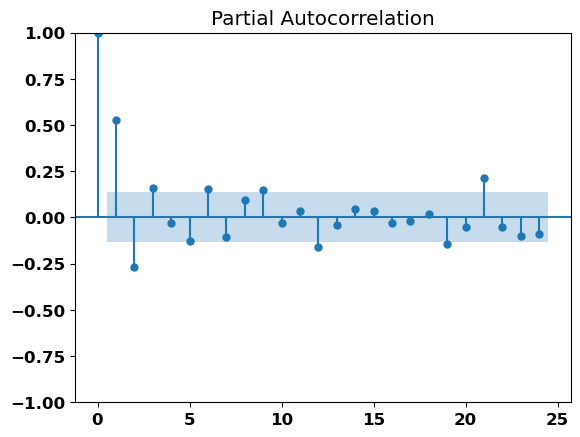

In [84]:
##plot_acf is used to identify the p parameter 
plot_pacf(train);

check p parameter value of 4

In [85]:
ar_1 = ARIMA(train, order=(4, 1, 2)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred = ar_1.predict(typ='levels')

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [86]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  210
Model:                 ARIMA(4, 1, 2)   Log Likelihood               -1629.799
Date:                Tue, 28 Mar 2023   AIC                           3273.599
Time:                        18:22:07   BIC                           3296.995
Sample:                    06-01-1996   HQIC                          3283.058
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0272      0.158     -0.173      0.863      -0.336       0.282
ar.L2          0.1761      0.112      1.571      0.116      -0.044       0.396
ar.L3         -0.1598      0.056     -2.873      0.004      -0.269      -0.051
ar.L4          0.1948      0.049      4.004      0.000       0.099       0.290
ma.L1         -0.2639      0.163     -1.622      0.105      -0.583       0.055
ma.L2         -0.7361      0.175     -4.209      0.000      -1.079      -0.393
sigma2      3.404e+05   3.11e-07    1.1e+12      0.000     3.4e+05     3.4e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                61.30
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):              38.74   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.89e+27. Standard errors may be unstable.
"""

In [87]:
from sklearn.metrics import mean_squared_error
import numpy as np

np.sqrt(mean_squared_error(train, train_pred))

584.0314566471898

In [88]:
ar_2 = ARIMA(train, order=(1, 0, 1)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred2 = ar_2.predict(typ='levels')

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [89]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  210
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1637.937
Date:                Tue, 28 Mar 2023   AIC                           3283.874
Time:                        18:22:07   BIC                           3297.263
Sample:                    06-01-1996   HQIC                          3289.287
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.8095     79.759      0.299      0.765    -132.515     180.134
ar.L1          0.2458      0.075      3.268      0.001       0.098       0.393
ma.L1          0.4403      0.074      5.946      0.000       0.295       0.585
sigma2      3.496e+05   2.12e+04     16.456      0.000    3.08e+05    3.91e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                92.12
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):              40.89   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
np.sqrt(mean_squared_error(train, train_pred2))

589.7028639993878

In [91]:
ar_3 = ARIMA(train, order=(4, 0, 3)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred3 = ar_3.predict(typ='levels')

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/anni

In [92]:
ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  210
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -1628.515
Date:                Tue, 28 Mar 2023   AIC                           3275.030
Time:                        18:22:08   BIC                           3305.154
Sample:                    06-01-1996   HQIC                          3287.208
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.3183    104.068      0.224      0.823    -180.651     227.288
ar.L1          0.2190      0.130      1.683      0.092      -0.036       0.474
ar.L2          0.6490      0.119      5.444      0.000       0.415       0.883
ar.L3          0.1949      0.082      2.375      0.018       0.034       0.356
ar.L4         -0.1197      0.063     -1.904      0.057      -0.243       0.004
ma.L1          0.5581      0.132      4.242      0.000       0.300       0.816
ma.L2         -0.6599      0.191     -3.449      0.001      -1.035      -0.285
ma.L3         -0.8187      0.120     -6.822      0.000      -1.054      -0.583
sigma2       3.18e+05   2.33e+04     13.652      0.000    2.72e+05    3.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                44.78
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              31.24   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
np.sqrt(mean_squared_error(train, train_pred3))

562.6294049570199

In [94]:
ar_4 = ARIMA(train, order=(2, 0, 1)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred4 = ar_4.predict(typ='levels')

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [95]:
ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  210
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1637.307
Date:                Tue, 28 Mar 2023   AIC                           3284.615
Time:                        18:22:08   BIC                           3301.350
Sample:                    06-01-1996   HQIC                          3291.380
                         - 11-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.8095     74.381      0.320      0.749    -121.975     169.594
ar.L1          0.3772      0.138      2.733      0.006       0.107       0.648
ar.L2         -0.1230      0.091     -1.344      0.179      -0.302       0.056
ma.L1          0.3218      0.145      2.215      0.027       0.037       0.607
sigma2      3.495e+05   2.26e+04     15.445      0.000    3.05e+05    3.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                79.33
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              38.82   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [96]:
np.sqrt(mean_squared_error(train, train_pred4))

587.8836602379504

In [97]:
y_pred = ar_2.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ar_2.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

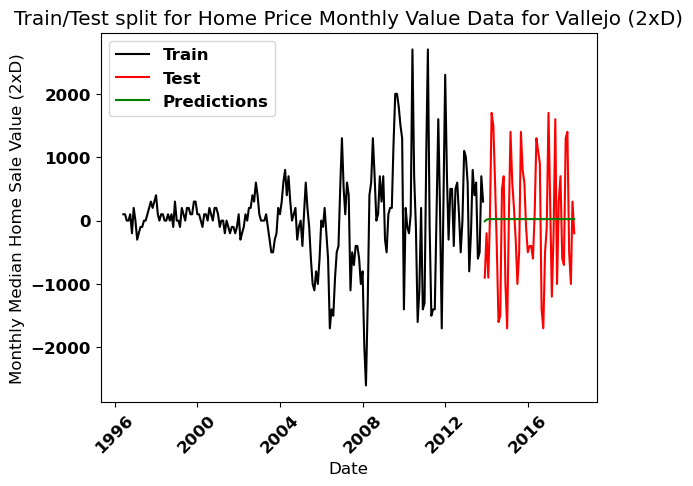

In [98]:
plt.plot(train, color = "black",label='Train')
plt.plot(test, color = "red",label='Test')
plt.ylabel('Monthly Median Home Sale Value (2xD)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Home Price Monthly Value Data for Vallejo (2xD)")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend();

## Seasonal Decomp Modeling

In [103]:
v_sdecomp

time
1996-10-01    0.154944
1996-11-01    0.170553
1996-12-01    0.610323
1997-01-01    1.057425
1997-02-01    1.165763
                ...   
2017-06-01   -0.366711
2017-07-01   -0.697404
2017-08-01   -0.424511
2017-09-01   -0.614664
2017-10-01   -1.478893
Name: resid, Length: 253, dtype: float64

In [107]:
# find the index which allows us to split off 20% of the data
cutoff_vsd = round(v_sdecomp.shape[0]*0.8) #cut off point at 80% of the data
cutoff_vsd

202

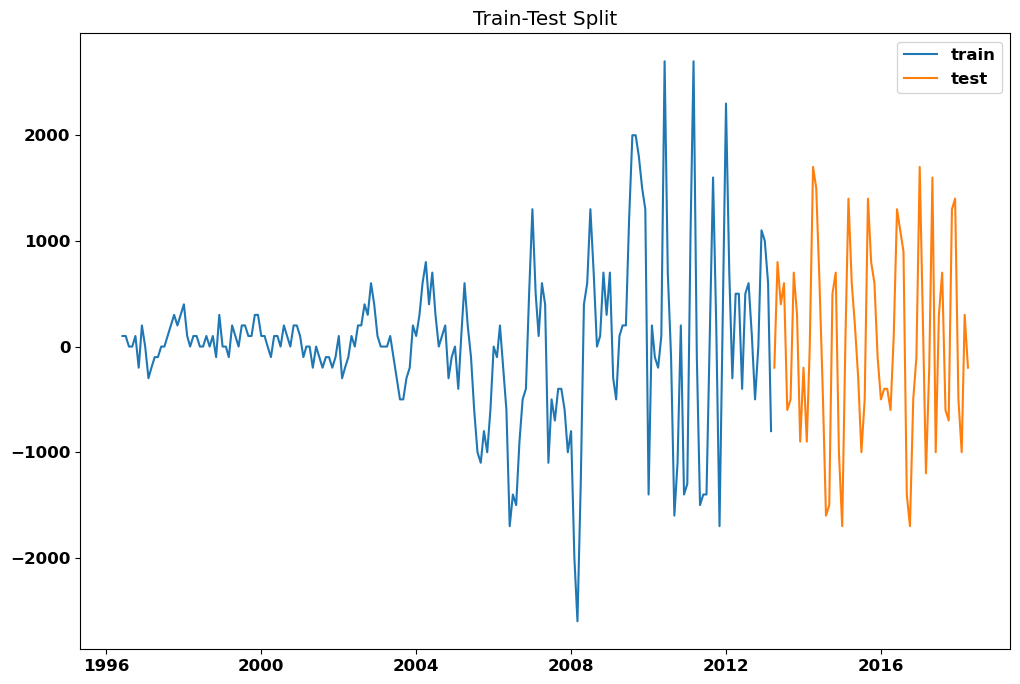

In [108]:
# Define train and test sets according to the index found above
train = diff2[:cutoff_vsd] #before cut off is train set -- 80%

test = diff2[cutoff_vsd:] #after cut off is the test set --20%

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [109]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
baseline = train.shift(1)
baseline

value
time              
1996-06-01     NaN
1996-07-01   100.0
1996-08-01   100.0
1996-09-01     0.0
1996-10-01     0.0
...            ...
2012-11-01  -500.0
2012-12-01     0.0
2013-01-01  1100.0
2013-02-01  1000.0
2013-03-01   600.0

[202 rows x 1 columns]

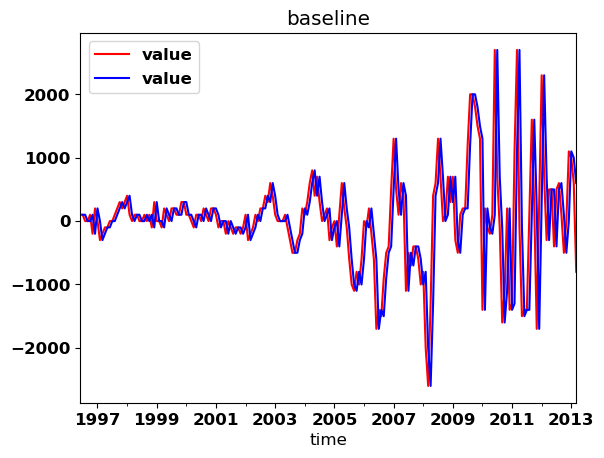

In [110]:
fig, ax = plt.subplots()

train.plot(ax=ax, c='r', label='original')
baseline.plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

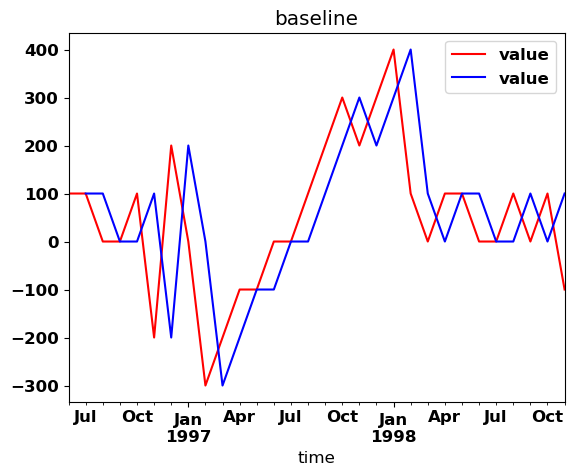

In [111]:
#A closer look
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [112]:
np.sqrt(mean_squared_error(train[1:], baseline.dropna()))

702.9787368602354

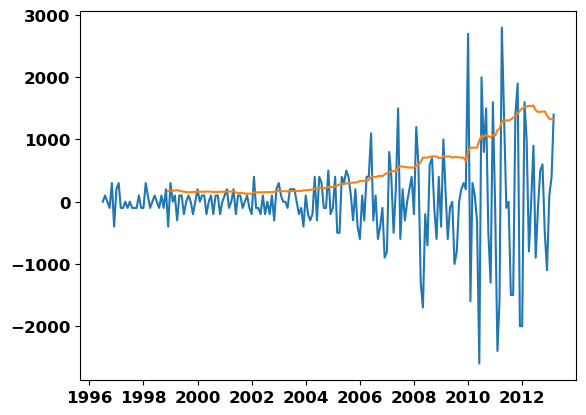

In [113]:
fig, ax = plt.subplots()
residuals = baseline[1:] - train[1:] #shift minus the train
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



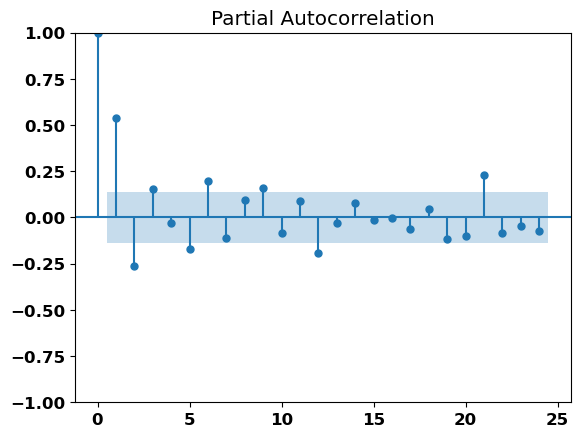

In [115]:
##plot_acf is used to identify the p parameter 
plot_pacf(train);

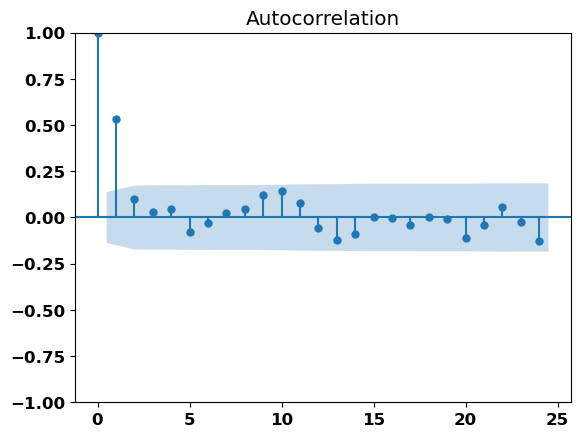

In [114]:
#Plot_acf is used to identify the q parameter
plot_acf(train);

In [116]:
ar_1 = ARIMA(train, order=(1, 0, 1)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred = ar_1.predict(typ='levels')

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [117]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  202
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1575.852
Date:                Tue, 28 Mar 2023   AIC                           3159.705
Time:                        18:34:12   BIC                           3172.938
Sample:                    06-01-1996   HQIC                          3165.059
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3267     83.653      0.207      0.836    -146.630     181.284
ar.L1          0.2715      0.075      3.619      0.000       0.124       0.418
ma.L1          0.4288      0.075      5.747      0.000       0.283       0.575
sigma2      3.507e+05   2.14e+04     16.350      0.000    3.09e+05    3.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                97.63
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):              44.50   Skew:                             0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [118]:
from sklearn.metrics import mean_squared_error
import numpy as np

np.sqrt(mean_squared_error(train, train_pred))

590.5675232698094

In [121]:
y_pred = ar_1.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ar_1.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"]

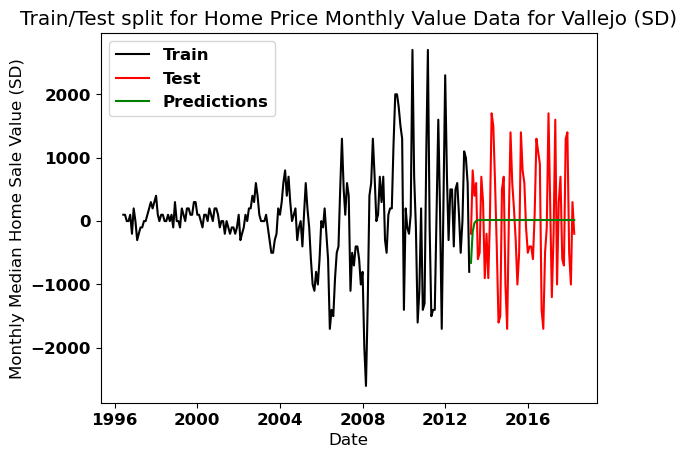

In [123]:
plt.plot(train, color = "black",label='Train')
plt.plot(test, color = "red",label='Test')
plt.ylabel('Monthly Median Home Sale Value (SD)')
plt.xlabel('Date')
plt.xticks(rotation=0)
plt.title("Train/Test split for Home Price Monthly Value Data for Vallejo (SD)")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.legend();

In [119]:
ar_2 = ARIMA(train, order=(4, 0, 3)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
train_pred = ar_2.predict(typ='levels')

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Users/anniezheng/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Users/anni

In [120]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  202
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -1560.757
Date:                Tue, 28 Mar 2023   AIC                           3139.515
Time:                        18:35:39   BIC                           3169.289
Sample:                    06-01-1996   HQIC                          3151.561
                         - 03-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.0179     86.528      0.197      0.844    -152.574     186.610
ar.L1         -1.3647      0.502     -2.720      0.007      -2.348      -0.381
ar.L2         -0.5386      0.367     -1.466      0.143      -1.259       0.181
ar.L3          0.0473      0.104      0.454      0.650      -0.157       0.252
ar.L4          0.0320      0.102      0.313      0.754      -0.168       0.232
ma.L1          2.2114      0.507      4.358      0.000       1.217       3.206
ma.L2          1.9163      0.786      2.437      0.015       0.375       3.458
ma.L3          0.5831      0.460      1.269      0.205      -0.318       1.484
sigma2      3.175e+05   2.47e+04     12.847      0.000    2.69e+05    3.66e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                44.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              28.38   Skew:                            -0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Step 6: Interpreting Results